In [103]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler
from scipy.special import expit
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve
from scipy.stats import norm
from collections import Counter

def read_dataset(path):
    df = pd.read_csv(path, skiprows=0)
    y = df['label'].to_numpy()
    X = df.drop('label', axis=1).to_numpy()
    return X, y

def scale_data(data):
    return MinMaxScaler().fit_transform(data)   

X_cancer, tmp_y_cancer = read_dataset('cancer.csv')
y_cancer = np.array([1 if l == 'M' else 0 for l in tmp_y_cancer])
X_cancer = scale_data(X_cancer)

X_spam, y_spam = read_dataset('spam.csv')
X_spam = scale_data(X_spam)

X_blobs, y_blobs = read_dataset('blobs2.csv')

In [67]:
def perform_svm(X, y, kernel, degree=3):
    clf = SVC(gamma='auto', kernel=kernel, degree=degree)
    clf.fit(X, y)
    plt.scatter(X[:, 0], X[:, 1], c=y_blobs, s=30)

    xx = np.linspace(np.min(X[:, 0]),np.max(X[:, 0]), 100)
    yy = np.linspace(np.min(X[:, 1]),np.max(X[:, 1]), 100)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    Z = clf.decision_function(xy).reshape(XX.shape)

    plt.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])

    plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1])
    plt.show()
    print(f'Found {clf.n_support_} vectors')

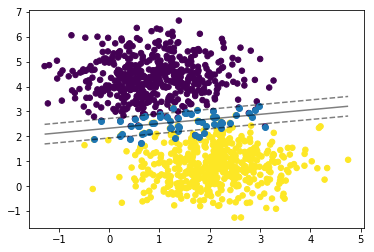

Found [29 30] vectors


In [68]:
perform_svm(X_blobs, y_blobs, 'linear')

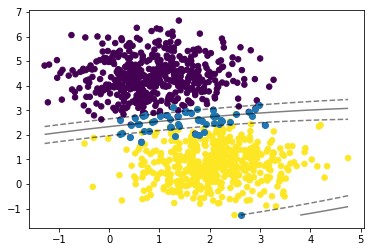

Found [26 27] vectors


In [69]:
perform_svm(X_blobs, y_blobs, 'poly', degree=2)

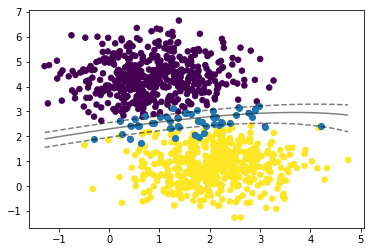

Found [25 25] vectors


In [70]:
perform_svm(X_blobs, y_blobs, 'poly', degree=3)

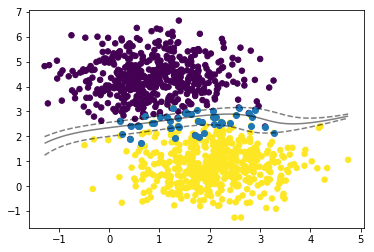

Found [24 24] vectors


In [71]:
perform_svm(X_blobs, y_blobs, 'poly', degree=5)

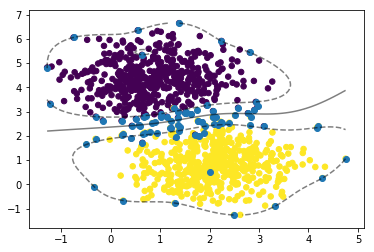

Found [41 42] vectors


In [72]:
perform_svm(X_blobs, y_blobs, 'rbf')

In [73]:
def compareSvmAndRandomForest(X_train, X_test, y_train, y_test):
    classifier = RandomForestClassifier(n_estimators=20, random_state=0)
    start = time.time()
    classifier.fit(X_train, y_train)
    print(f'Random forest time is {(time.time() - start):.3f}s')
    y_pred = classifier.predict(X_test)
    print(f'Random forest accuracy is {accuracy_score(y_test, y_pred)}')  

    clf = SVC(gamma='auto', kernel='linear')
    start = time.time()
    clf.fit(X_train, y_train)
    print(f'SVM time is {(time.time() - start):.3f}s')
    print(f'SVM accuracy is {clf.score(X_test, y_test)}')

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X_spam, y_spam, test_size=0.2)
compareSvmAndRandomForest(X_train, X_test, y_train, y_test)

Random forest time is 0.100s
Random forest accuracy is 0.9609120521172638
SVM time is 0.312s
SVM accuracy is 0.9033659066232356


In [75]:
X_train, X_test, y_train, y_test = train_test_split(X_cancer, y_cancer, test_size=0.2)
compareSvmAndRandomForest(X_train, X_test, y_train, y_test)

Random forest time is 0.027s
Random forest accuracy is 0.9824561403508771
SVM time is 0.002s
SVM accuracy is 0.9912280701754386


**Bayesian classifier**

In [100]:
def bayseain_classifier(X, y, X_test):
    probs = np.ones((X_test.shape[0], 2))
    
    for f in tqdm_notebook(range(X.shape[1])):
        for l in [0, 1]:
            mean = np.mean(X[y == l][:, f])
            std = np.std(X[y == l][:, f])
            for i, x in enumerate(X_test):
                density = norm.pdf(x[f], loc=mean, scale=std)
                probs[i, l] *= density
    probs[:, 0] *= np.sum(y == 0)
    probs[:, 1] *= np.sum(y == 1)
    scaled_probs = np.zeros_like(probs)
    scaled_probs[:, 0] = probs[:, 0] / np.sum(probs, axis=1)
    scaled_probs[:, 1] = probs[:, 1] / np.sum(probs, axis=1)
    scaled_probs = np.nan_to_num(scaled_probs)
    return np.argmax(probs, axis=1), scaled_probs

def apply_nb_classifier(X_train, X_test, y_train, y_test):
    y_pred, probs = bayseain_classifier(X_train, y_train, X_test)
    print(f'Accuracy is {accuracy_score(y_test, y_pred)}')
    frp, tpr, _ = roc_curve(y_test, probs[:, 0])
    plt.plot(tpr.tolist(), frp.tolist())


Accuracy is 0.9473684210526315


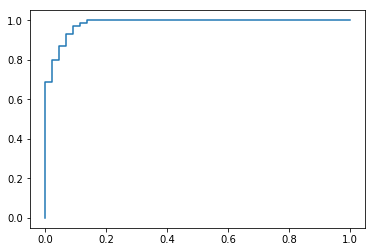

In [101]:
X_train, X_test, y_train, y_test = train_test_split(X_cancer, y_cancer, test_size=0.2)
apply_nb_classifier(X_train, X_test, y_train, y_test)


Accuracy is 0.8099891422366993


/Users/andrey/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  
/Users/andrey/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


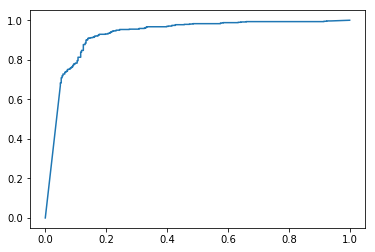

In [102]:
X_train, X_test, y_train, y_test = train_test_split(X_spam, y_spam, test_size=0.2)
apply_nb_classifier(X_train, X_test, y_train, y_test)

In [174]:
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import PorterStemmer
# nltk.download('punkt')
X_smsspam, y_smsspam = read_dataset('smsspam.csv')
y_smsspam = np.array([0 if y == "ham" else 1 for y in y_smsspam])

def create_dictionary(X, y):
    dictinary = [Counter(), Counter()]
    words = set()
    ps = PorterStemmer()
    for x, label in zip(X, y):
        for word in word_tokenize(x[0]):
            word = ps.stem(word)
            dictinary[label][word] += 1
            words.add(word)
    return dictinary, words

def descrete_bayseain_classifier(X, y, X_test, dictionary, all_words):
    probs = np.ones((X_test.shape[0], 2))
    for l in [0, 1]:
        size = np.sum(y == l)
        for word in tqdm_notebook(all_words):
            for i, x in enumerate(X_test):
                if word in x[0]:
                    probs[i, l] *= (dictionary[l][word] + 1) / (size + 2)
                else:
                    probs[i, l] *= (size - dictionary[l][word] + 1) / (size + 2)
    probs[:, 0] *= np.sum(y == 0)
    probs[:, 1] *= np.sum(y == 1)
    scaled_probs = np.zeros_like(probs)
    scaled_probs[:, 0] = probs[:, 0] / np.sum(probs, axis=1)
    scaled_probs[:, 1] = probs[:, 1] / np.sum(probs, axis=1)
    scaled_probs = np.nan_to_num(scaled_probs)
    return np.argmax(probs, axis=1), scaled_probs

Accuracy is 0.9327354260089686


/Users/andrey/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/Users/andrey/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide


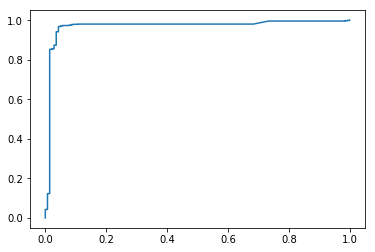

In [175]:
X_train, X_test, y_train, y_test = train_test_split(X_smsspam, y_smsspam, test_size=0.2)
dictionary, all_words = create_dictionary(X_train, y_train)

y_pred, probs = descrete_bayseain_classifier(X_train, y_train, X_test, dictionary, all_words)
print(f'Accuracy is {accuracy_score(y_test, y_pred)}')
frp, tpr, _ = roc_curve(y_test, probs[:, 0], pos_label=1)
plt.plot(tpr.tolist(), frp.tolist())
